In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['axes.grid'] = True

from matplotlib import animation
from numba import jit
from tqdm import tqdm
from scipy import special
from itertools import cycle
import matplotlib.cm as cm

# 1.1

## B (time stepping)

In [3]:
def f1(xs):
    return np.sin(2 * np.pi * xs)

def f2(xs):
    return np.sin(5 * np.pi * xs)

def f3(xs):
    tmp = []
    for x in xs:
        if 1/5 < x and x < 2/5:
            tmp.append(np.sin(5 * np.pi * x))
        else:
            tmp.append(0)
    return np.asarray(tmp)

In [4]:
def time_stepping(f, L=1, c=1, delta_t=0.001):
    ts = np.arange(0, 1, delta_t)
    N = len(ts)
    
    xs = np.arange(0, L, L / N)
    
    t0 = f(xs)    
    all_ts = [t0, t0]
    
    for t in ts:
        tmp_x = helper(L, N, (1, len(xs)-1), delta_t, [all_ts[-2], all_ts[-1]])
        all_ts.append(tmp_x)
    return xs, all_ts, ts

def helper(L, N, x_range, delta_t, old_ts):
    new_ts = [0]
    for i in range(x_range[0], x_range[1]):
        new_step = (delta_t * 1) / (L / N) * (old_ts[-1][i+1] + old_ts[-1][i-1] - 2 * old_ts[-1][i]) - old_ts[-2][i] + 2 * old_ts[-1][i]
        new_ts.append(new_step)
    new_ts.append(0)
    return new_ts

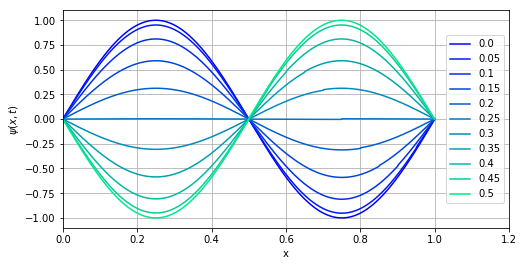

In [5]:
### f1

xs, ts, t = time_stepping(f1)
plt.figure(figsize=(8,4))

for i in range(0,11):
    c = cm.winter(i/11.,1)
    index = i * 50
    plt.plot(xs, ts[index], label= round(t[index],2), color=c)
    
plt.legend(loc='center right', bbox_to_anchor=(1,0.5), fancybox=True)
plt.xlabel("x")
plt.xlim([0,1.2])
plt.ylabel(r'$\psi(x,t)$')
# plt.savefig('wave-eq-1.pdf')
plt.show()

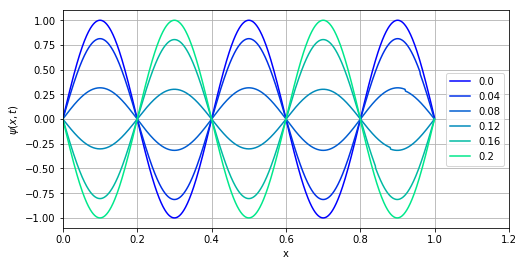

In [6]:
### f2

xs, ts, t = time_stepping(f2)
plt.figure(figsize=(8,4))

for i in range(0,11, 2):
    c = cm.winter(i/11.,1)
    index = i * 20
    plt.plot(xs, ts[index], label= round(t[index],2), color=c)
    
plt.legend(loc='center right', bbox_to_anchor=(1,0.5), fancybox=True)
plt.xlabel("x")
plt.xlim([0,1.2])
plt.ylabel(r'$\psi(x,t)$')
# plt.savefig('wave-eq-2.pdf')
plt.show()

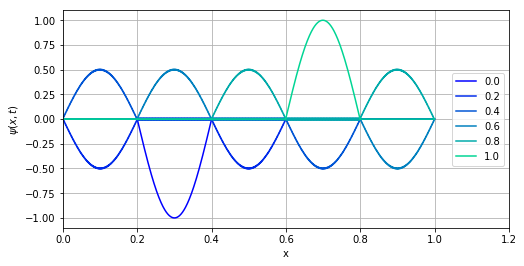

In [7]:
### f3

xs, ts, t = time_stepping(f3)
plt.figure(figsize=(8,4))

for i in range(0,6):
    c = cm.winter(i/6.,1)
    if i == 5:
        index = 999
    else:
        index = i * 200
    plt.plot(xs, ts[index], label= round(t[index],2), color=c)
    
plt.legend(loc='center right', bbox_to_anchor=(1,0.5), fancybox=True)
plt.xlabel("x")
plt.xlim([0,1.2])
plt.ylabel(r'$\psi(x,t)$')
# plt.savefig('wave-eq-3.pdf')
plt.show()

## C

In [42]:
def animate_plot(func, name):
    xs, ts, t = time_stepping(func)

    fig = plt.figure()
    ax = plt.axes(xlim=(0, 1), ylim=(-2, 2))
    line, = ax.plot([], [], lw=2)

    # initialization function: plot the background of each frame
    def init():
        line.set_data([], [])
        return line,

    # animation function.  This is called sequentially
    def animate(i):
        line.set_data(xs, ts[i])
        return line,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=1000, interval=10, blit=True)

    anim.save(name, fps=100, extra_args=['-vcodec', 'libx264'])

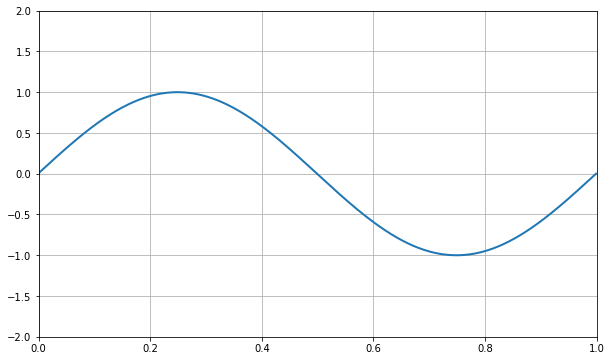

In [43]:
animate_plot(f1, "f1.mp4")

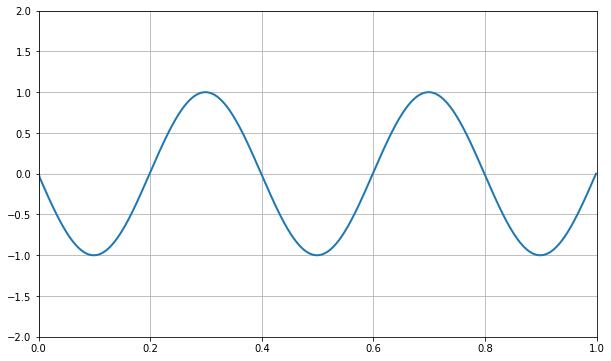

In [44]:
animate_plot(f2, "f2.mp4")

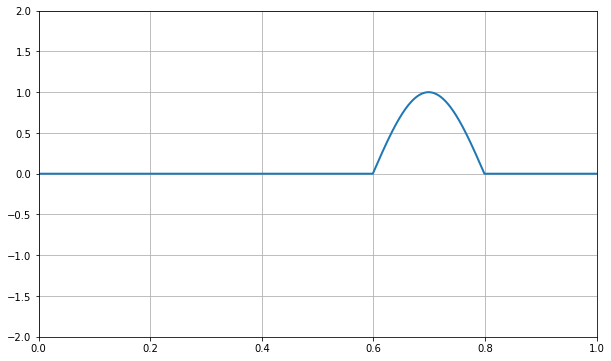

In [45]:
animate_plot(f3, "f3.mp4")

# 1.2

## E

In [3]:
def diffusion(delta_t, u0, D=1):
    N = u0.shape[0]
    
    if (4 * delta_t * D) / (1 / N) ** 2 > 1:
        raise Exception("Unstable scheme")
        
    # initialize new timestep    
    u1 = np.zeros((N, N))
    
    # fill in new timestep
    for i in range(N):
        if i == 0:
            u1[i] = np.ones((1, N))
        elif i == N-1:
            u1[i] = np.zeros((1, N))
        else:            
            for j in range(N):
                ln = j - 1
                rn = j + 1
                
                # periodic boundaries
                if j == 0:
                    ln = N-1
                elif j == N-1:
                    rn = 0
                    
                u1[i][j] = u0[i][j] + ((delta_t * D) / (1 / N)**2) * (u0[i+1][j] + u0[i-1][j] + u0[i][rn] + u0[i][ln] - 4 * u0[i][j])
    return u1

def rep_diffusion(N=10, delta_t=0.001, rep=100):
    us = []
    
    u0 = np.zeros((N, N))
    u0[0] = np.ones((1, N))
    
    us.append(u0)
    
    for _ in range(rep):
        ut = diffusion(delta_t, us[-1])
        us.append(ut)
    return us

In [6]:
# Analytical solution
def c(x, t, D=1):
    tmp = 0
    for i in range(0, 1000):
        tmp += special.erfc((1 - x + 2 * i) / (2 * np.sqrt(D*t))) - special.erfc((1 + x + 2 * i) / (2 * np.sqrt(D*t)))
    return tmp

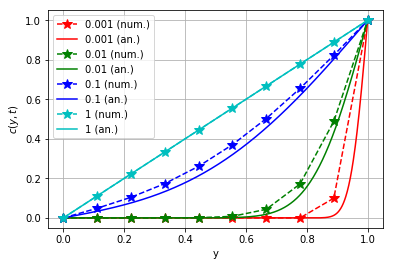

In [5]:
x = np.linspace(0, 1, 1000)
x2 = np.linspace(0, 1, 10)

colors = cycle(["r", "g", "b", "c", "m", "y"])

for t in [0.001, 0.01, 0.1, 1]:
    line_color = next(colors)
    
    c_num = rep_diffusion(delta_t=0.001, rep=int(t*1000))[-1][:,0][::-1].T
    plt.plot(x2, c_num, "*--", c=line_color, label=str(t) + " (num.)", markersize=10)
    plt.plot(x, c(x, t), c=line_color, label=str(t) + " (an.)")
    
plt.legend()
##plt.title("Time Dependent Diffusion Equation numerical vs analytical")
plt.xlabel("y")
plt.ylabel(r'$c(y,t)$')
# plt.savefig('time-dep-an-vs-num.pdf')
plt.show()

## F

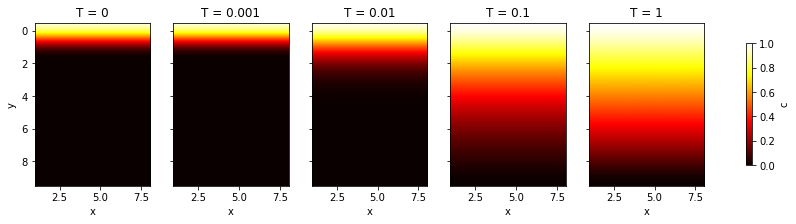

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharex='col', sharey='row')

for i, t in enumerate([0, 0.001, 0.01, 0.1, 1]):
    c_num = rep_diffusion(delta_t=0.001, rep=int(t*1000-1))[-1]
    
    ax = axes.flat[i]
    im = ax.imshow(c_num, vmin=0, vmax=1, interpolation="bicubic", cmap=plt.get_cmap('hot'))
    ax.set_title("T = " + str(t))
    ax.grid('off')
    ax.set_xlabel('x')
    if t == 0:
        ax.set_ylabel('y')

fig.colorbar(im, ax=axes.ravel().tolist(),shrink=0.75).set_label('c')
plt.savefig('diff-heatmap.pdf')
plt.show()

## G

In [7]:
def animate(images, name):
    fig = plt.figure()

    ims = []
    for img in images:
        im = plt.imshow(img, animated=True, interpolation="bicubic", cmap=plt.get_cmap('hot'))
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)

    ani.save(name)

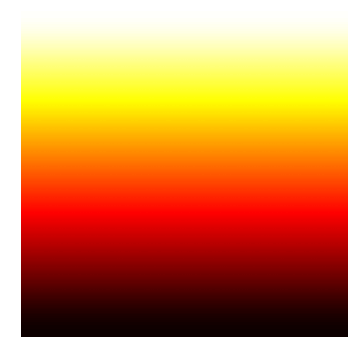

In [54]:
us = rep_diffusion(delta_t = 0.001, rep=1000)
animate(us, "time_dependent.mp4")

# 1.7

## H

In [9]:
@jit(nopython=True)
def time_independent(f, mask, N=50, epsilon=10e-5, omega=1):
    if mask.shape[0] != N:
         raise Exception("Mask and N have different dimensions")  
    
    u = np.zeros((N, N))
    u[0] = np.ones((1, N))

    new = u
    old = np.full((N, N), np.inf)
    
    iterations = 0

    while(np.amax(np.abs(new - old)) >= epsilon):
        old = np.copy(u) 
        for i in range(1, N-1):
            for j in range(N):
                ln = j - 1
                rn = j + 1

                # periodic boundaries
                if j == 0:
                    ln = N-1
                elif j == N-1:
                    rn = 0
                    
                if f == "jacobi":
                    u0 = old
                    u[i][j] = (1/4) * (u0[i+1][j] + u0[i-1][j] + u0[i][rn] + u0[i][ln])
                    
                # Gaus and sor together
                elif f == "gaussor":
                    if mask[i][j] == 0:
                        u[i][j] = 0
                    else:                        
                        u0 = old
                        u[i][j] = (omega/4) * (u[i+1][j] + u[i-1][j] + u[i][rn] + u[i][ln]) + (1 - omega) * (u0[i][j])
                else:
                    raise Exception("Unkown function")
        new = u
                
        iterations += 1
                
    return u, iterations

In [4]:
N = 50
NO_MASK_50 = np.ones((N, N)) # MACRO, used to keep time_independent numba-appropiate
ts = np.linspace(0, 1, N)

In [7]:
y_jacobi = time_independent("jacobi", NO_MASK_50)[0][:,0][::-1].T
y_gausseidel = time_independent("gaussor", NO_MASK_50)[0][:,0][::-1].T
y_sor17 = time_independent("gaussor", NO_MASK_50, omega=1.7)[0][:,0][::-1].T
y_sor18 = time_independent("gaussor", NO_MASK_50, omega=1.8)[0][:,0][::-1].T

analytical = c(ts, 1.0, D=1)

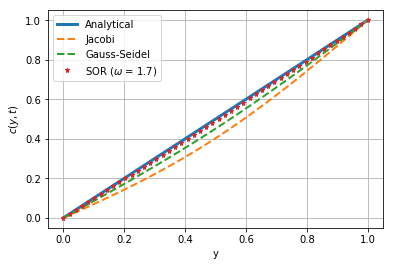

In [8]:
#plt.title("Result for different solutions to diffusion equation (T=1)")
plt.plot(ts, analytical, label="Analytical", linewidth=3)

plt.plot(ts, y_jacobi, "--", label="Jacobi", linewidth=2)
plt.plot(ts, y_gausseidel, "--", label="Gauss-Seidel", linewidth=2)
plt.plot(ts, y_sor17, "*", label=r"SOR ($\omega$ = 1.7)", markersize=5)


plt.xlabel("y")
plt.ylabel(r'$c(y,t)$')

plt.legend()
# plt.savefig('different-sol-diff.pdf')
plt.show()

## I

In [9]:
ys_jacobi = []
ys_gausseidel = []
ys_sor17 = []
ys_sor18 = []
ys_sor19 = []

epsilons = [10**-3, 10**-4, 10**-5, 10**-6]

for ep in tqdm(epsilons):
    ys_jacobi.append(time_independent("jacobi", NO_MASK_50, epsilon=ep)[1])
    ys_gausseidel.append(time_independent("gaussor", NO_MASK_50, epsilon=ep)[1])
    ys_sor17.append(time_independent("gaussor", NO_MASK_50, epsilon=ep, omega=1.7)[1])
    ys_sor18.append(time_independent("gaussor", NO_MASK_50, epsilon=ep, omega=1.8)[1])
    ys_sor19.append(time_independent("gaussor", NO_MASK_50, epsilon=ep, omega=1.9)[1])

100%|██████████| 4/4 [00:05<00:00,  1.58s/it]


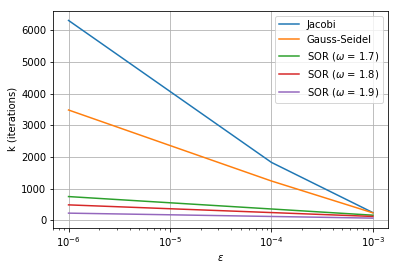

In [10]:
#lt.title("Convergence for different solutions to diffusion equation (N = 50)")
plt.xscale("log")
plt.plot(epsilons, ys_jacobi, label="Jacobi")
plt.plot(epsilons, ys_gausseidel, label="Gauss-Seidel")
plt.plot(epsilons, ys_sor17, label=r"SOR ($\omega$ = 1.7)")
plt.plot(epsilons, ys_sor18, label=r"SOR ($\omega$ = 1.8)")
plt.plot(epsilons, ys_sor19, label=r"SOR ($\omega$ = 1.9)")
plt.xlabel(r"$\epsilon$")
plt.ylabel("k (iterations)")

plt.legend()
# plt.savefig('diff-epsilon.pdf')
plt.show()

## J

In [11]:
oms = np.linspace(1.71, 1.99, 50)
ns = [100]
all_reps = []

for n in tqdm(ns):
    reps = []
    for om in oms:
        reps.append(time_independent("gaussor", np.ones((n, n)), N=n, epsilon=10e-5, omega=om)[1])
    all_reps.append(reps)

100%|██████████| 1/1 [00:21<00:00, 22.00s/it]


N = 100, rep = 191, omega = 1.96142857143


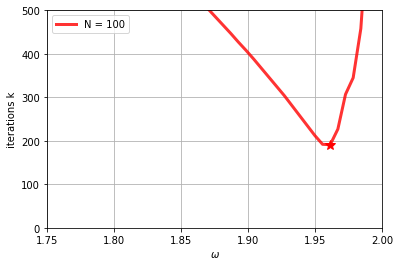

In [15]:
colors = cycle(["r", "g", "b", "c", "m", "y"])

for i, rep in enumerate(all_reps):
    line_color = next(colors)
    plt.plot(oms[rep.index(min(rep))], min(rep), "*", c=line_color, markersize=10)
    print("N = " + str(ns[i]) + ", rep = " + str(min(rep)) + ", omega = " + str(oms[rep.index(min(rep))]))
    plt.plot(oms, rep, label="N = " + str(ns[i]), alpha=0.8, c=line_color, linewidth=3)

plt.xlabel(r"$\omega$")
plt.ylabel("iterations k")
plt.ylim(0, 500)
plt.xlim(1.75, 2.00)
plt.legend(loc='upper left')
# plt.savefig('optimal-omega.pdf')
plt.show()

## K

In [67]:
# MASKS
mask_big_square = np.ones((N, N))
print(mask_big_square.shape)
for i in range(N):
    for j in range(N):
        if (j >= N // 2 - 10 and j <= N // 2 + 10) and (i >= N // 2 - 20 and i <= N // 2):
            mask_big_square[i][j] = 0
            
mask_two_squares = np.ones((N, N))
for i in range(N):
    for j in range(N):
        if (((j >= N // 2 - 15 and j <= N // 2 - 5) and (i >= N // 2 - 20 and i <= N // 2)) or
            ((j >= N // 2 + 5 and j <= N // 2 + 15) and (i >= N // 2 - 20 and i <= N // 2))):
            mask_two_squares[i][j] = 0
            
mask_three_squares = np.ones((N, N))
for i in range(N):
    for j in range(N):
        if (((j >= N // 2 - 20 and j <= N // 2 - 15) and (i >= N // 2 - 20 and i <= N // 2)) or
            ((j >= N // 2 - 5 and j <= N // 2 + 5) and (i >= N // 2 - 20 and i <= N // 2)) or 
            ((j >= N // 2 + 15 and j <= N // 2 + 20) and (i >= N // 2 - 20 and i <= N // 2))):
            mask_three_squares[i][j] = 0

(50, 50)


122 iterations
100 iterations
98 iterations
82 iterations


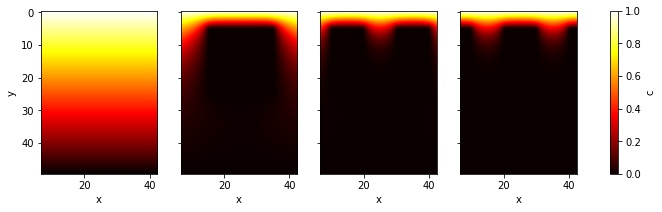

In [68]:
NO_MASK = np.ones((50, 50))

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3), sharex='col', sharey='row')
for i, mask in enumerate([NO_MASK, mask_big_square, mask_two_squares, mask_three_squares]):
    im, iterations = time_independent("gaussor", mask, omega=1.9)
    ax = axes.flat[i]
    im = ax.imshow(im, interpolation="bicubic", cmap=plt.get_cmap('hot'))
    print(str(iterations) + " iterations")
    ax.grid('off')
    ax.set_xlabel('x')

axes.flat[0].set_ylabel('y')

fig.colorbar(im, ax=axes.ravel().tolist()).set_label('c')
# plt.savefig('diffusion-objects.pdf')
plt.show()

In [69]:
oms = np.linspace(1.71, 1.99, 50)

for i, mask in enumerate([NO_MASK, mask_big_square, mask_two_squares, mask_three_squares]):
    reps = []
    
    for om in oms:
        _, rep = time_independent("gaussor", mask, N=50, epsilon=10e-5, omega=om)
        reps.append(rep)
        
    print(oms[reps.index(min(reps))])

1.92142857143
1.83571428571
1.75571428571
1.71


## Optional

In [70]:
@jit(nopython=True)
def insulation(mask, delta_t, u0, D=1):
    N = u0.shape[0]
    
    if (4 * delta_t * D) / (1 / N) ** 2 > 1:
        raise Exception("Unstable scheme")
    
    u1 = np.zeros((N, N))

    for i in range(N):
        if i == 0:
            u1[i] = np.ones((1, N))
        elif i == N-1:
            u1[i] = np.zeros((1, N))
        else:            
            for j in range(N):
                ln = j - 1
                rn = j + 1
                
                # periodic boundaries
                if j == 0:
                    ln = N-1
                elif j == N-1:
                    rn = 0
                    
                if mask[i][j] == 0:
                    u1[i][j] = u0[i][j] + ((delta_t * (1/10)) / (1 / N)**2) * (u0[i+1][j] + u0[i-1][j] + u0[i][rn] + u0[i][ln] - 4 * u0[i][j])
                else:
                    u1[i][j] = u0[i][j] + ((delta_t * D) / (1 / N)**2) * (u0[i+1][j] + u0[i-1][j] + u0[i][rn] + u0[i][ln] - 4 * u0[i][j])
    return u1

@jit(nopython=True)
def rep_insulation(mask, N=10, delta_t=0.001, rep=1000):
    us = []
    
    u0 = np.zeros((N, N))
    u0[0] = np.ones((1, N))
    
    us.append(u0)
    
    for _ in range(rep):
        ut = insulation(mask, delta_t, us[-1])
        us.append(ut)
    return us

In [71]:
mask_small_square = np.ones((10, 10))
    
for i in range(10):
    for j in range(10):
        if (j >= 3 and j <= 6) and (i >= 2 and i <= 5):
            mask_small_square[i][j] = 0

In [73]:
p = rep_insulation(mask_small_square)

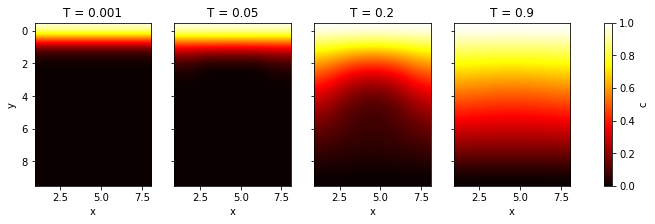

In [76]:
t1 = p[1]
t2 = p[5]
t3 = p[200]
t4 = p[900]

ts = [1*0.001, 50*0.001, 200*0.001, 900*0.001]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3), sharex='col', sharey='row')
for i, t in enumerate([t1, t2, t3, t4]):
    ax = axes.flat[i]
    im = ax.imshow(t, interpolation="bicubic", cmap=plt.get_cmap('hot'))
    ax.set_title("T = " + str(ts[i]))
    ax.grid('off')
    ax.set_xlabel('x')

axes.flat[0].set_ylabel('y')

fig.colorbar(im, ax=axes.ravel().tolist()).set_label('c')
# plt.savefig('insulation-objects.pdf')
plt.show()